In [122]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

In [123]:
df=pd.read_csv("Data/water_dataX.csv")
gdf = gpd.read_file('Data/india-states/Igismap/Indian_States.shp')
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes
df = df.iloc[0:1901, :]

In [124]:
# Checking for datatypes of the dataset
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (�mhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [125]:
#convertir le types des donneés d'un certains variables en float
df['Temp']=pd.to_numeric(df['Temp'], errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'], errors='coerce')
df['PH']=pd.to_numeric(df['PH'], errors='coerce')
df['CONDUCTIVITY (�mhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (�mhos/cm)'], errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'], errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'], errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

In [126]:
df.dtypes

STATION CODE                         object
LOCATIONS                            object
STATE                                object
Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (�mhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

In [127]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'D.O. (mg/l)': 'DO'})
df = df.rename(columns={'CONDUCTIVITY (�mhos/cm)': 'CONDUCTIVITY'})
df = df.rename(columns={'B.O.D. (mg/l)': 'BOD'})
df = df.rename(columns={'NITRATENAN N+ NITRITENANN (mg/l)': 'NITRATE_N_NITRITE_N'})
df = df.rename(columns={'FECAL COLIFORM (MPN/100ml)': 'FECAL_COLIFORM'})
df = df.rename(columns={'TOTAL COLIFORM (MPN/100ml)Mean': 'TOTAL_COLIFORM'})
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014


C:\Users\amine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BOD', ylabel='Density'>

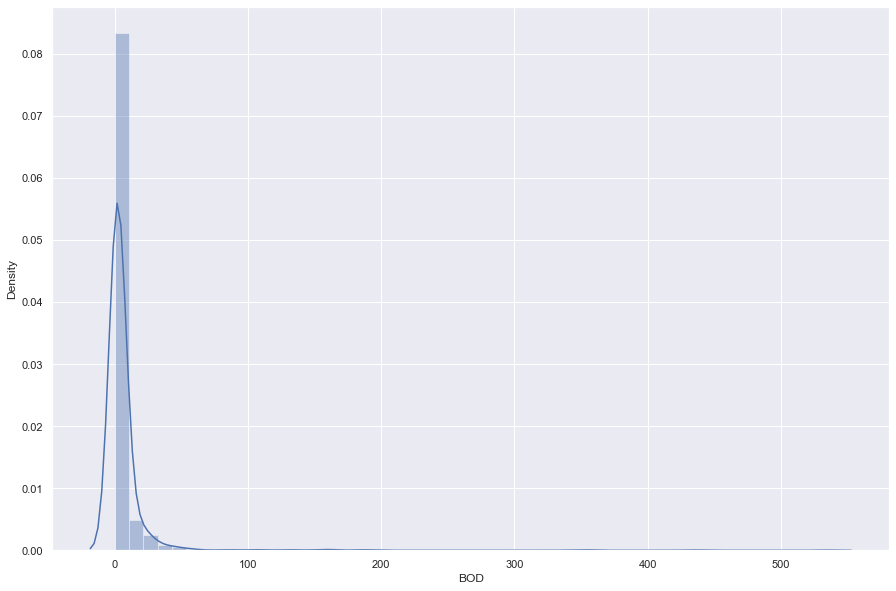

In [135]:
sns.set(rc={'figure.figsize':(15,10)})
fig, (ax1)=plt.subplots(1,1)
sns.distplot(df['BOD'], ax=ax1)

In [136]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

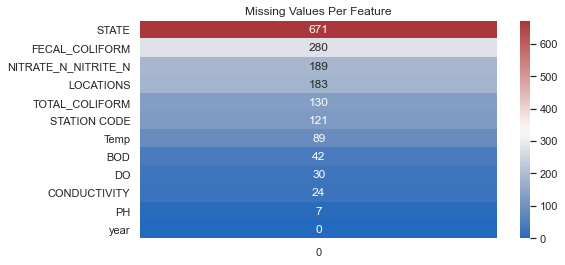

In [137]:
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [138]:
df_num = df.select_dtypes(exclude="object")# Selectioner les donneés numériques
df_num_col = df_num.columns 
imputer = SimpleImputer(strategy="median")#crée un objet imputer à l'aide de la classe SimpleImputer
#Remplacer toutes les valeurs manquantes dans les données numériques par la valeur médiane de chaque colonne
df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [139]:
# Filling Categorical missing values
df_temp = df.select_dtypes(include="object")
df_temp.isnull().sum()

STATION CODE    121
LOCATIONS       183
STATE           671
dtype: int64

In [140]:
# ici on peut remplir ces valeurs par observer les autres attributs
# Exemple - 
pd.set_option('mode.chained_assignment', None)
df_temporaire = df_temp.copy()

df_temporaire[df_temporaire["STATION CODE"] == "1330"]
# Station Code qui a la valeur 1330 du Location - TAMBIRAPARANI qui appartient à STATE - TAMIL NADU
#je peux remplacer les occuerences du valeur NAN dans la case STATE par TAMILNADU
df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"] = df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [141]:
# Les valeurs NULL dans l’attribut LOCATION sont dans l’attribut STATE (ex - au-dessus du dataframe)
# Ainsi, je remplirai les valeurs NULL dans l’attribut LOCATION avec la valeur STATE correspondante
# Et la valeur d’état sera remplacée par la fonction "fill_state" définie en dessous de cette cellule

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [142]:
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [143]:
# je peux remplir les valeurs NULL du code de la station avec la valeur LOCATION correspondante (ex - au-dessus de la base de données)
#je vais faire la valeur LOCATION correspondante avec une autre valeur LOCATION identique et insérera la valeur du code station

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_temporaire)
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [144]:
# Remplissage de toutes les valeurs NAN d’état qui ont une valeur de code de station correspondante
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [145]:
df_temporaire.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [146]:
df_temporaire[df_temporaire["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [147]:
# Le premier emplacement KABBANI AT MUTHANKARA est dans l’ÉTAT Kerela
df_temporaire["STATE"][1106] = "KERALA"
df_temporaire["STATE"][1107] = "KERALA"
df_temporaire["STATE"][1650] = "CHANDIGARH"
df_temporaire["STATE"][1651] = "CHANDIGARH"
df_temporaire["STATE"][1652] = "CHANDIGARH"
df_temporaire["STATE"][1770] = "CHANDIGARH"
df_temporaire["STATE"][1771] = "CHANDIGARH"
df_temporaire["STATE"][1772] = "CHANDIGARH"
df_temporaire["STATE"][1784] = "DAMAN & DIU"
df_temporaire["STATE"][1785] = "DAMAN & DIU"
df_temporaire["STATION CODE"][1784] = "0000" 
df_temporaire["STATION CODE"][1785] = "0000"

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

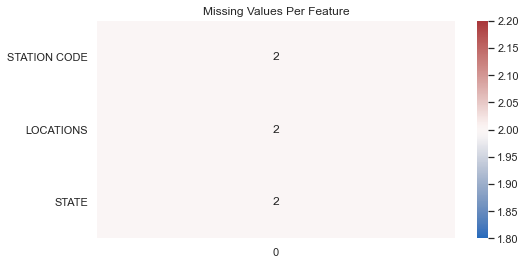

In [148]:
df_res = df_temporaire
plt.title('Missing Values Per Feature')
nans = df_res.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

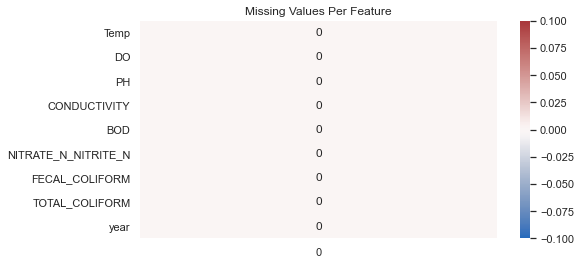

In [149]:
plt.title('Missing Values Per Feature')
nans = df_num.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

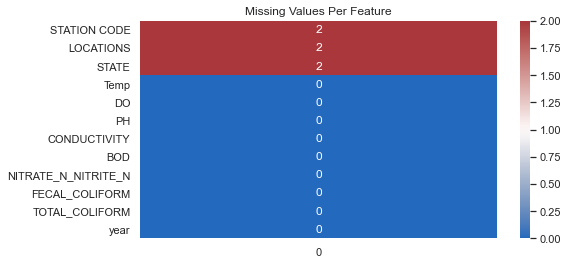

In [150]:
df_final = pd.concat([df_res, df_num], axis=1)
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

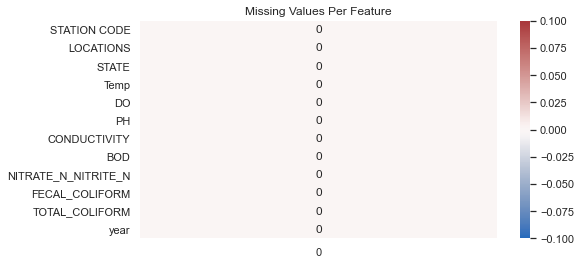

In [151]:
# Ce sont les exemples qui ne contiennent aucun attribut
# Les attributs remplis sont la médiane des colonnes correspondantes
# Il est donc préférable de les supprimer
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [152]:
df_final.shape

(1899, 12)

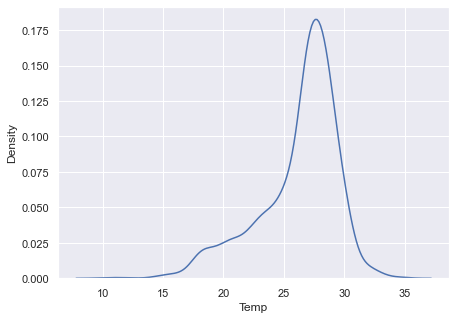

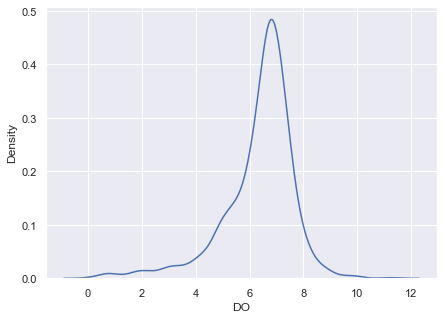

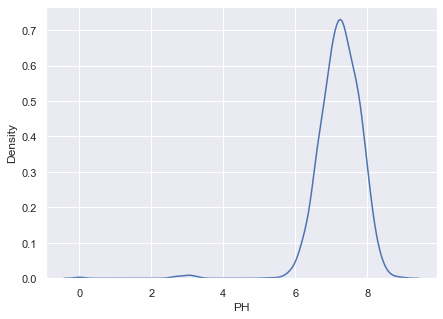

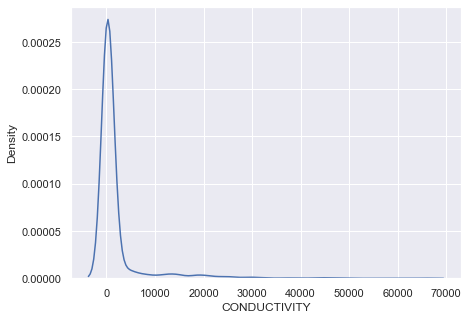

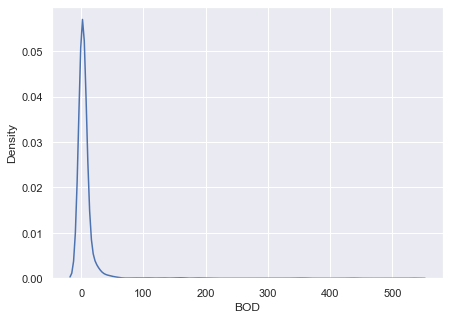

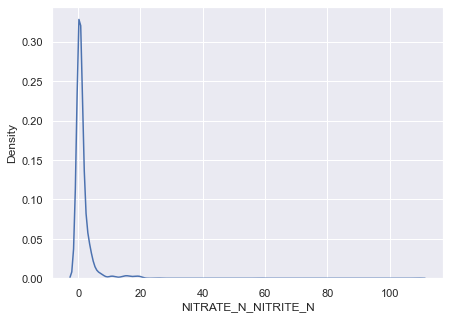

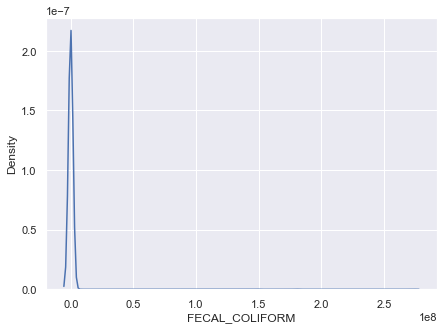

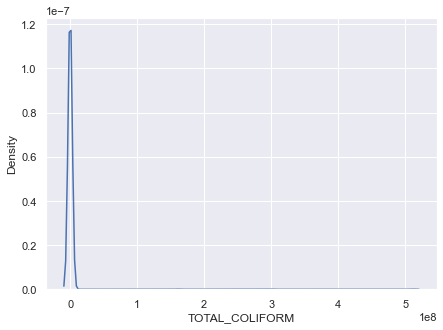

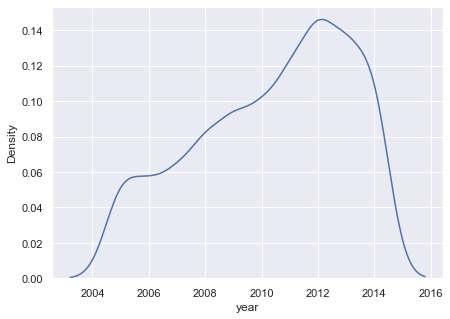

In [153]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [154]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method:  125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [155]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1786, 12)

In [156]:
df_final.shape

(1786, 12)

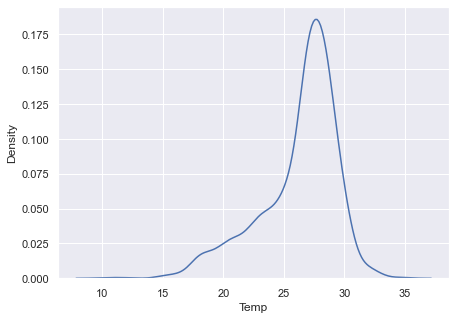

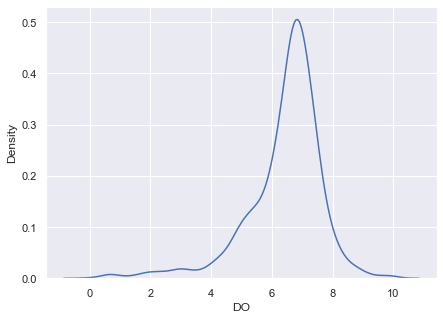

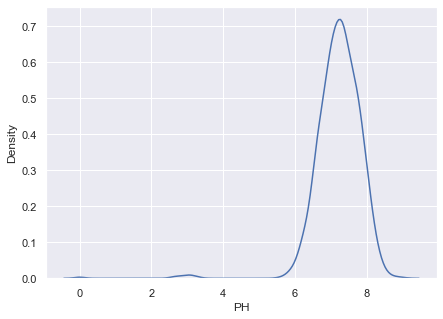

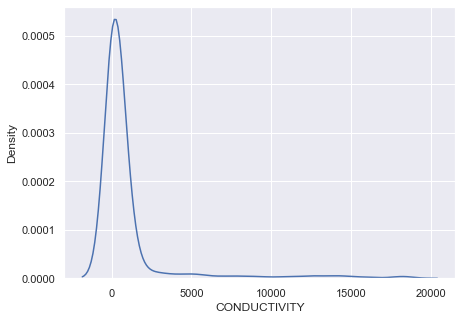

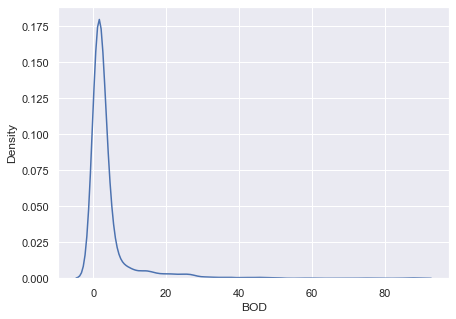

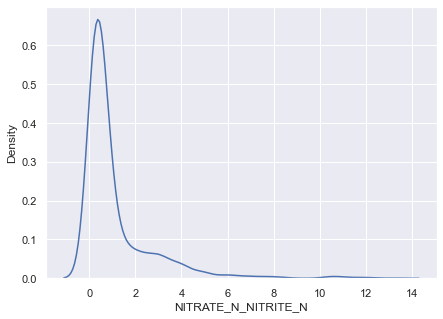

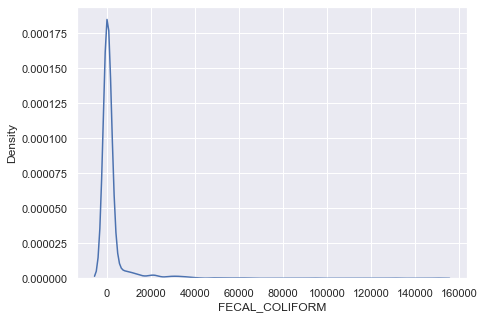

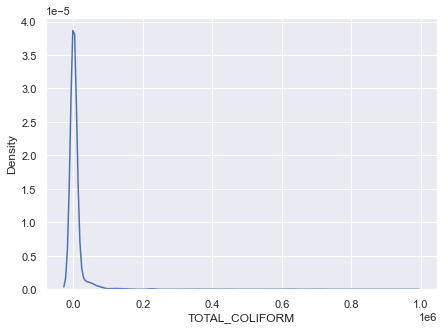

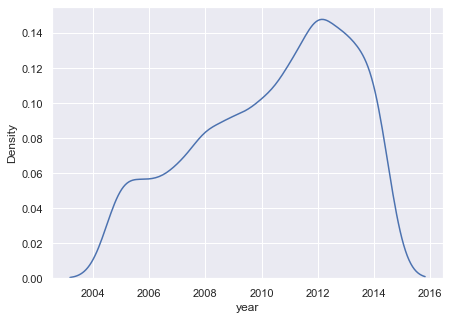

In [157]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

C:\Users\amine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BOD', ylabel='Density'>

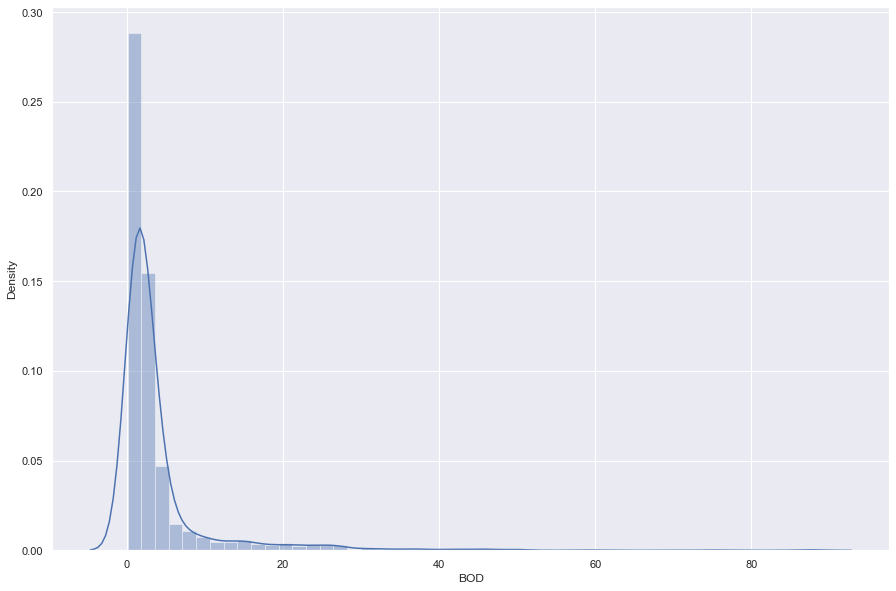

In [158]:
sns.set(rc={'figure.figsize':(15,10)})
fig, (ax1)=plt.subplots(1,1)
sns.distplot(df_final['BOD'], ax=ax1)

In [112]:
df_final.corr()

,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
Temp,1.000000,-0.026121,0.041882,0.117039,-0.200007,-0.411607,-0.201958,-0.179591,-0.008231
DO,-0.026121,1.000000,0.057498,-0.141057,-0.413259,-0.191473,-0.245900,-0.145332,0.017024
PH,0.041882,0.057498,1.000000,0.049776,0.087442,0.026086,0.100674,0.078191,0.019545
CONDUCTIVITY,0.117039,-0.141057,0.049776,1.000000,0.083769,0.023310,0.010421,-0.000218,-0.011567
BOD,-0.200007,-0.413259,0.087442,0.083769,1.000000,0.420598,0.347066,0.239606,-0.024866
NITRATE_N_NITRITE_N,-0.411607,-0.191473,0.026086,0.023310,0.420598,1.000000,0.335217,0.208030,0.085827
FECAL_COLIFORM,-0.201958,-0.245900,0.100674,0.010421,0.347066,0.335217,1.000000,0.674474,-0.045813
TOTAL_COLIFORM,-0.179591,-0.145332,0.078191,-0.000218,0.239606,0.208030,0.674474,1.000000,-0.099739
year,-0.008231,0.017024,0.019545,-0.011567,-0.024866,0.085827,-0.045813,-0.099739,1.000000


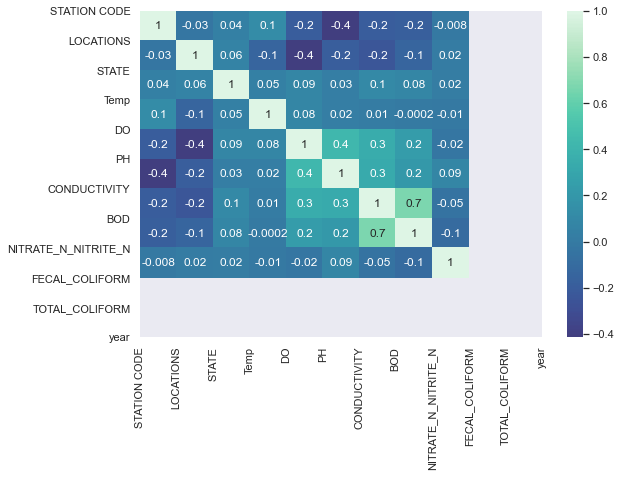

In [121]:
sns.set(rc={'figure.figsize':(9,6)})
hmap = sns.heatmap(df_final.corr(),center=0,annot=True, fmt='.1g', cmap="mako")
plt.xticks(range(len(df_final.columns)),df_final.columns)
plt.yticks(range(len(df_final.columns)),df_final.columns)
plt.show()

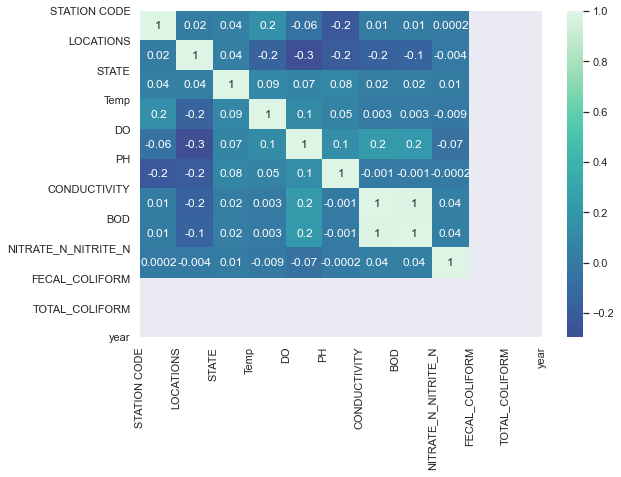

In [120]:
sns.set(rc={'figure.figsize':(9,6)})
hmap = sns.heatmap(df.corr(),center=0,annot=True, fmt='.1g', cmap="mako")
plt.xticks(range(len(df.columns)),df.columns)
plt.yticks(range(len(df.columns)),df.columns)
plt.show()

moyenne

In [159]:
df=pd.read_csv("Data/water_dataX.csv")
gdf = gpd.read_file('Data/india-states/Igismap/Indian_States.shp')
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes
df = df.iloc[0:1901, :]

In [160]:
# Checking for datatypes of the dataset
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (�mhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [161]:
#convertir le types des donneés d'un certains variables en float
df['Temp']=pd.to_numeric(df['Temp'], errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'], errors='coerce')
df['PH']=pd.to_numeric(df['PH'], errors='coerce')
df['CONDUCTIVITY (�mhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (�mhos/cm)'], errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'], errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'], errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

In [162]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'D.O. (mg/l)': 'DO'})
df = df.rename(columns={'CONDUCTIVITY (�mhos/cm)': 'CONDUCTIVITY'})
df = df.rename(columns={'B.O.D. (mg/l)': 'BOD'})
df = df.rename(columns={'NITRATENAN N+ NITRITENANN (mg/l)': 'NITRATE_N_NITRITE_N'})
df = df.rename(columns={'FECAL COLIFORM (MPN/100ml)': 'FECAL_COLIFORM'})
df = df.rename(columns={'TOTAL COLIFORM (MPN/100ml)Mean': 'TOTAL_COLIFORM'})
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014


In [163]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [164]:
df.shape

(1901, 12)

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

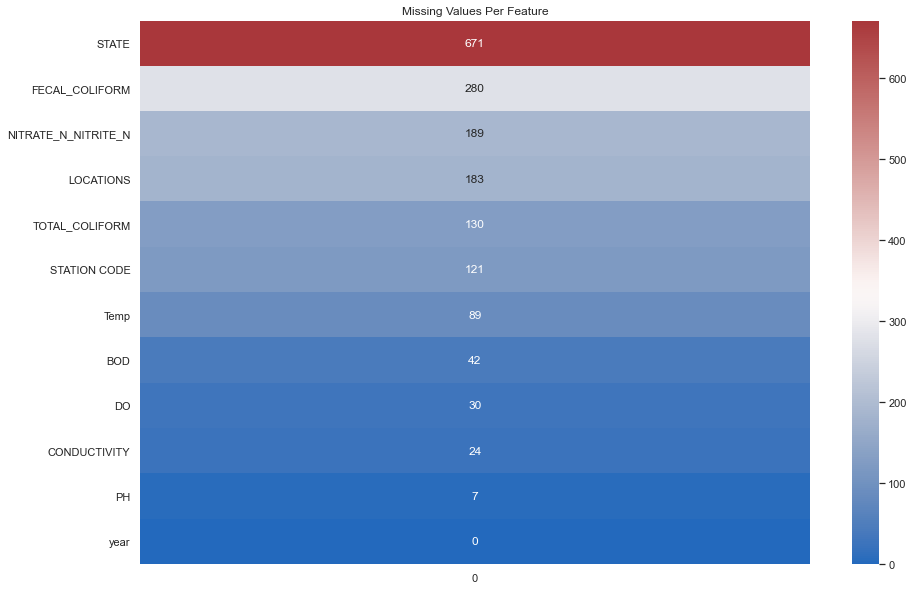

In [165]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [166]:
df_num = df.select_dtypes(exclude="object")# Selectioner les donneés numériques
df_num_col = df_num.columns 
imputer = SimpleImputer(strategy="mean")#crée un objet imputer à l'aide de la classe SimpleImputer
#Remplacer toutes les valeurs manquantes dans les données numériques par la valeur médiane de chaque colonne
df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [167]:
# Filling Categorical missing values
df_temp = df.select_dtypes(include="object")
df_temp.isnull().sum()

STATION CODE    121
LOCATIONS       183
STATE           671
dtype: int64

In [168]:
# ici on peut remplir ces valeurs par observer les autres attributs
# Exemple - 
pd.set_option('mode.chained_assignment', None)
df_temporaire = df_temp.copy()

df_temporaire[df_temporaire["STATION CODE"] == "1330"]
# Station Code qui a la valeur 1330 du Location - TAMBIRAPARANI qui appartient à STATE - TAMIL NADU
#je peux remplacer les occuerences du valeur NAN dans la case STATE par TAMILNADU
df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"] = df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [169]:
# Les valeurs NULL dans l’attribut LOCATION sont dans l’attribut STATE (ex - au-dessus du dataframe)
# Ainsi, je remplirai les valeurs NULL dans l’attribut LOCATION avec la valeur STATE correspondante
# Et la valeur d’état sera remplacée par la fonction "fill_state" définie en dessous de cette cellule

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [170]:
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [171]:
# je peux remplir les valeurs NULL du code de la station avec la valeur LOCATION correspondante (ex - au-dessus de la base de données)
#je vais faire la valeur LOCATION correspondante avec une autre valeur LOCATION identique et insérera la valeur du code station

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_temporaire)
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [172]:
# Remplissage de toutes les valeurs NAN d’état qui ont une valeur de code de station correspondante
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [173]:
df_temporaire.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [174]:
df_temporaire[df_temporaire["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [175]:
# Le premier emplacement KABBANI AT MUTHANKARA est dans l’ÉTAT Kerela
df_temporaire["STATE"][1106] = "KERALA"
df_temporaire["STATE"][1107] = "KERALA"
df_temporaire["STATE"][1650] = "CHANDIGARH"
df_temporaire["STATE"][1651] = "CHANDIGARH"
df_temporaire["STATE"][1652] = "CHANDIGARH"
df_temporaire["STATE"][1770] = "CHANDIGARH"
df_temporaire["STATE"][1771] = "CHANDIGARH"
df_temporaire["STATE"][1772] = "CHANDIGARH"
df_temporaire["STATE"][1784] = "DAMAN & DIU"
df_temporaire["STATE"][1785] = "DAMAN & DIU"
df_temporaire["STATION CODE"][1784] = "0000" 
df_temporaire["STATION CODE"][1785] = "0000"

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

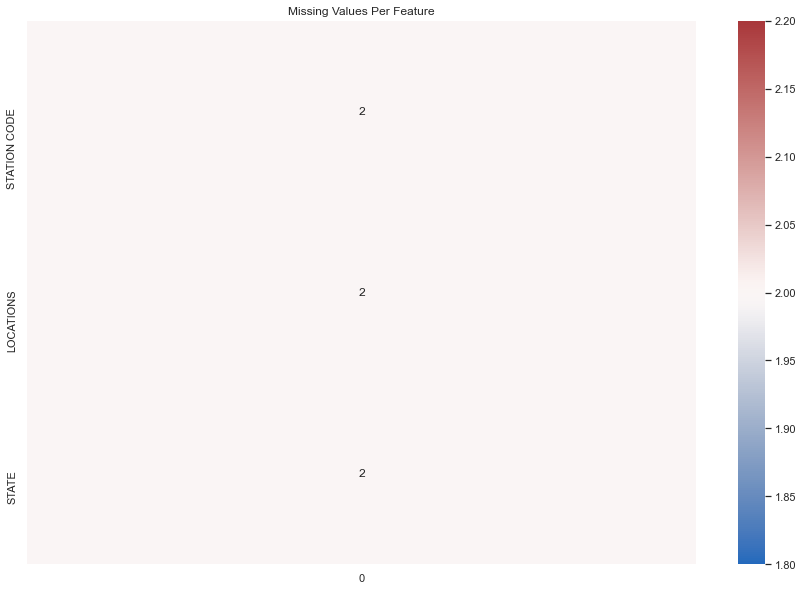

In [176]:
df_res = df_temporaire
plt.title('Missing Values Per Feature')
nans = df_res.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

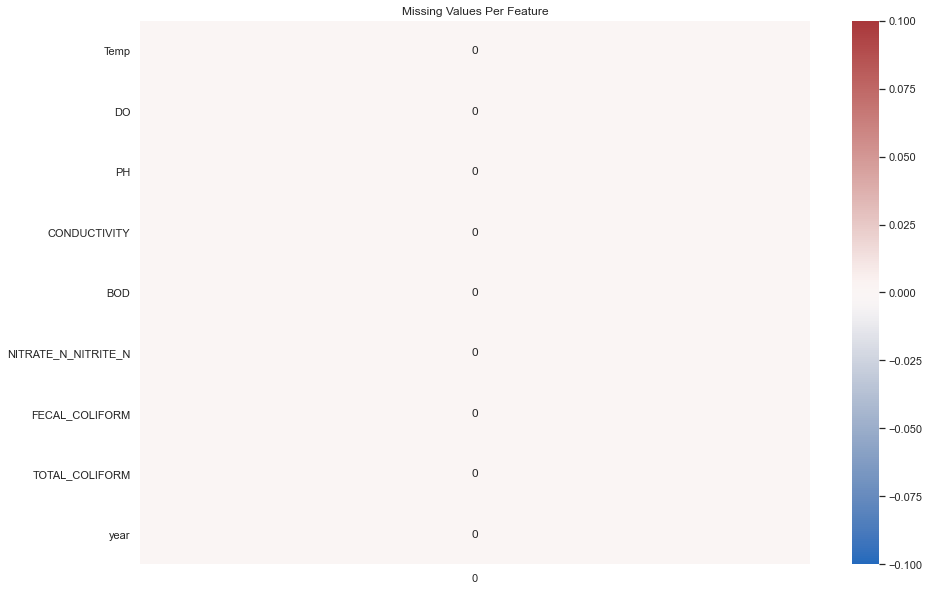

In [177]:
plt.title('Missing Values Per Feature')
nans = df_num.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

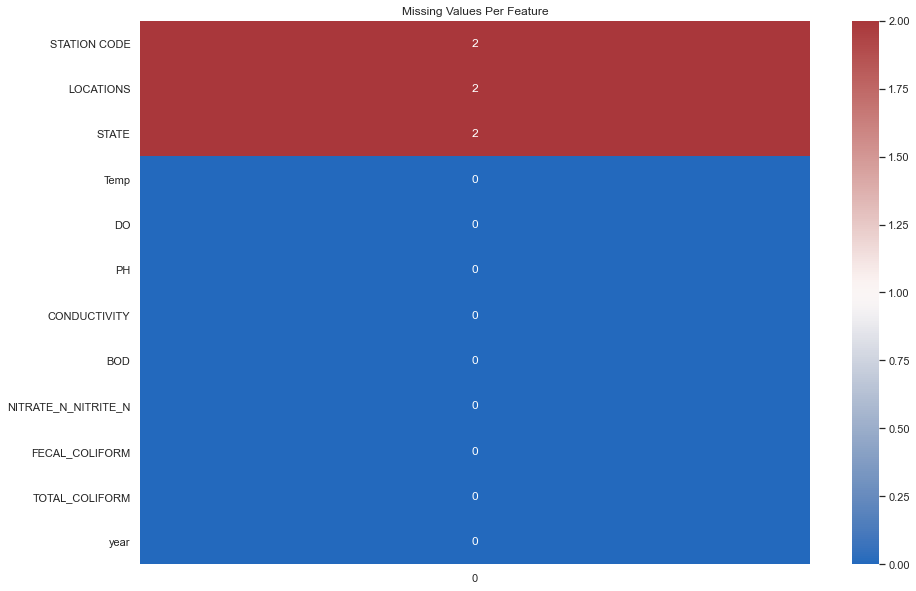

In [178]:
df_final = pd.concat([df_res, df_num], axis=1)
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

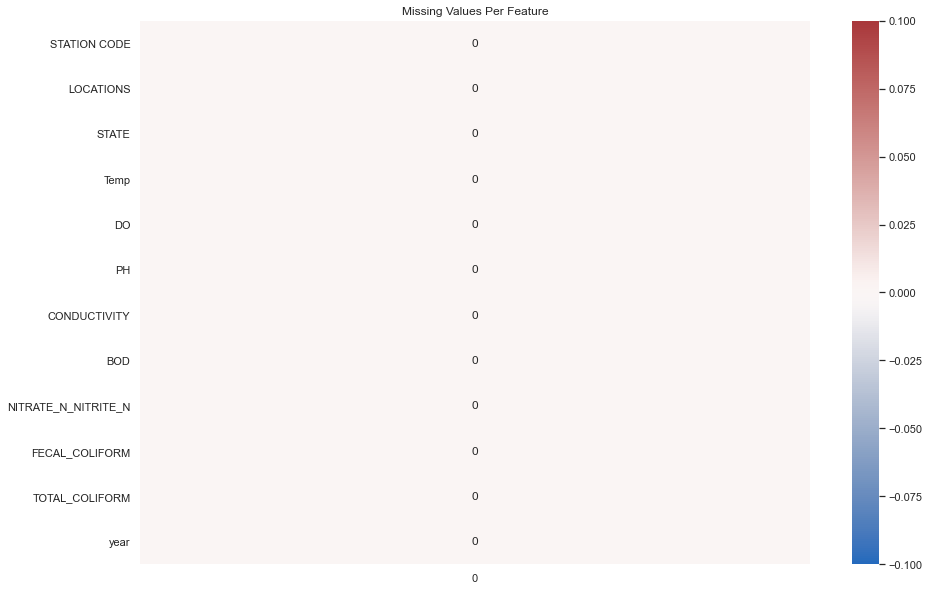

In [179]:
# Ce sont les exemples qui ne contiennent aucun attribut
# Les attributs remplis sont la médiane des colonnes correspondantes
# Il est donc préférable de les supprimer
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [180]:
df_final.shape

(1899, 12)

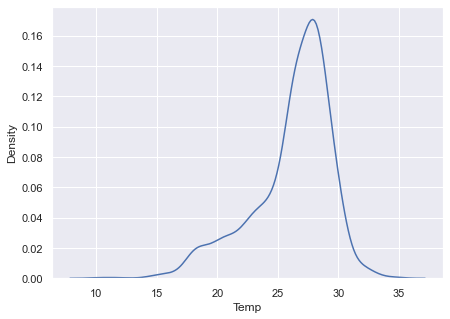

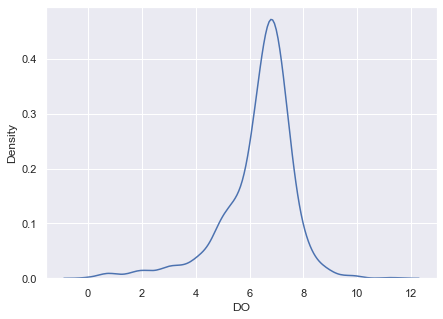

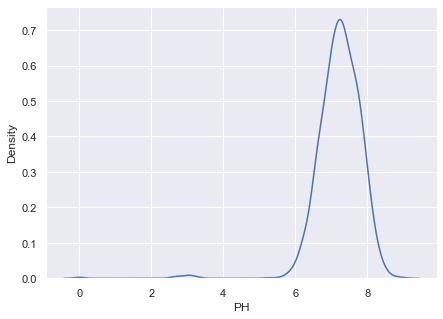

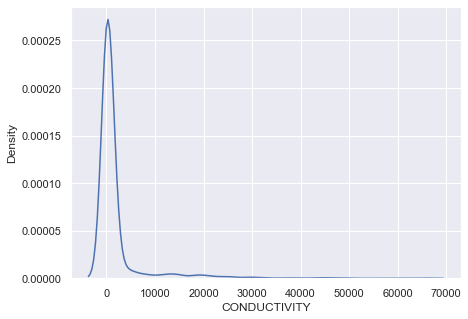

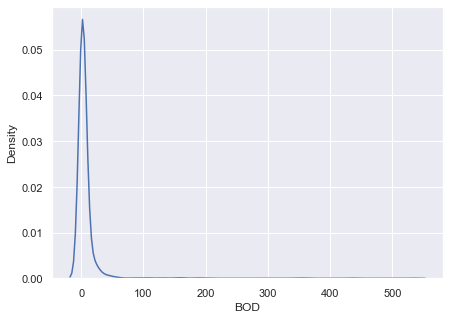

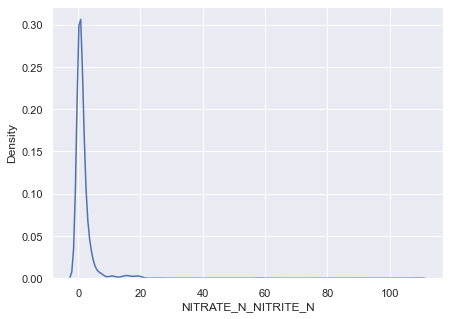

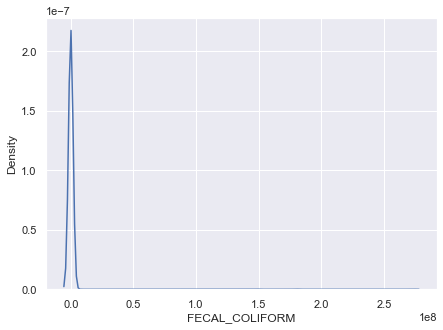

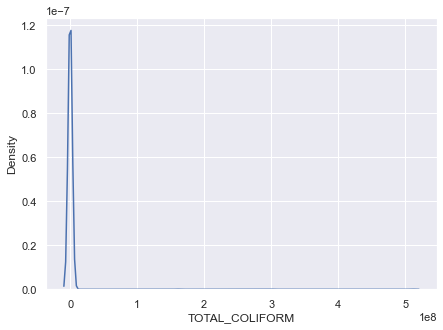

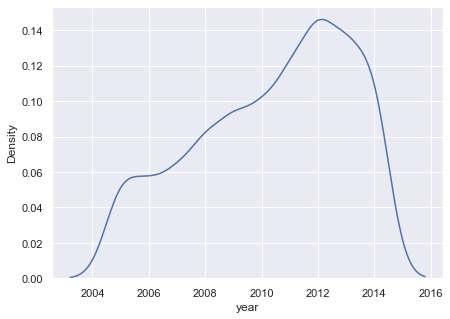

In [181]:
# PLotting PDFs of all the numeric attributes in the dataset

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [182]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method:  125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,1.65783,3.746062e+05,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,1.65783,3.746062e+05,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20000,1.560000e+02,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90000,4.000000e+04,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30000,9.200000e+01,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00000,1.328000e+03,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08000,1.400000e+03,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90000,2.725216e+08,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00000,1.328000e+03,4975.0,2013.0


In [183]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1786, 12)

C:\Users\amine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BOD', ylabel='Density'>

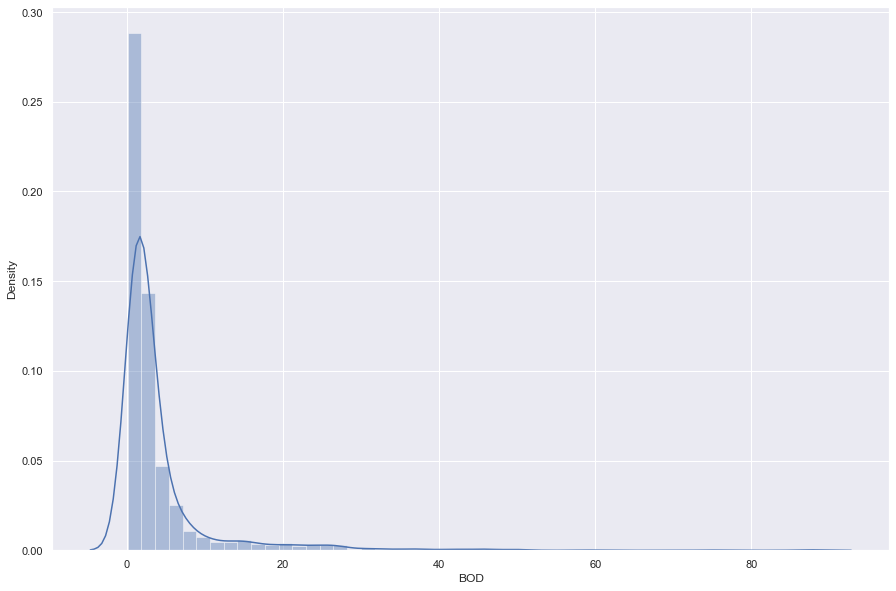

In [184]:
sns.set(rc={'figure.figsize':(15,10)})
fig, (ax1)=plt.subplots(1,1)
sns.distplot(df_final['BOD'], ax=ax1)

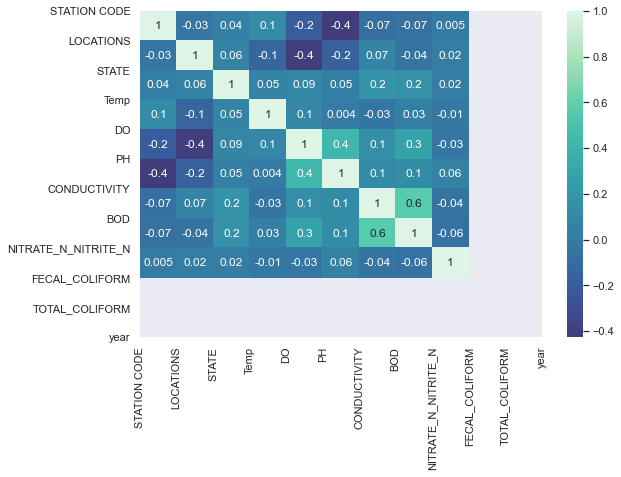

In [185]:
sns.set(rc={'figure.figsize':(9,6)})
hmap = sns.heatmap(df_final.corr(),center=0,annot=True, fmt='.1g', cmap="mako")
plt.xticks(range(len(df_final.columns)),df_final.columns)
plt.yticks(range(len(df_final.columns)),df_final.columns)
plt.show()

plus frequent

In [186]:
df=pd.read_csv("Data/water_dataX.csv")
gdf = gpd.read_file('Data/india-states/Igismap/Indian_States.shp')
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes
df = df.iloc[0:1901, :]

In [187]:
#afficher les 5 premiére lignes
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (�mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [188]:
#convertir le types des donneés d'un certains variables en float
df['Temp']=pd.to_numeric(df['Temp'], errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'], errors='coerce')
df['PH']=pd.to_numeric(df['PH'], errors='coerce')
df['CONDUCTIVITY (�mhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (�mhos/cm)'], errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'], errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'], errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

In [189]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'D.O. (mg/l)': 'DO'})
df = df.rename(columns={'CONDUCTIVITY (�mhos/cm)': 'CONDUCTIVITY'})
df = df.rename(columns={'B.O.D. (mg/l)': 'BOD'})
df = df.rename(columns={'NITRATENAN N+ NITRITENANN (mg/l)': 'NITRATE_N_NITRITE_N'})
df = df.rename(columns={'FECAL COLIFORM (MPN/100ml)': 'FECAL_COLIFORM'})
df = df.rename(columns={'TOTAL COLIFORM (MPN/100ml)Mean': 'TOTAL_COLIFORM'})
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014


In [190]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

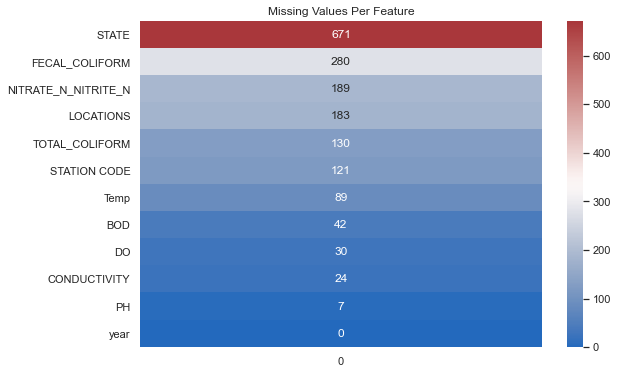

In [191]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [192]:
df_num = df.select_dtypes(exclude="object")# Selectioner les donneés numériques
df_num_col = df_num.columns 
imputer = SimpleImputer(strategy="most_frequent")#crée un objet imputer à l'aide de la classe SimpleImputer
#Remplacer toutes les valeurs manquantes dans les données numériques par la valeur médiane de chaque colonne
df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [193]:
# Filling Categorical missing values
df_temp = df.select_dtypes(include="object")
df_temp.isnull().sum()

STATION CODE    121
LOCATIONS       183
STATE           671
dtype: int64

In [194]:
# ici on peut remplir ces valeurs par observer les autres attributs
# Exemple - 
pd.set_option('mode.chained_assignment', None)
df_temporaire = df_temp.copy()

df_temporaire[df_temporaire["STATION CODE"] == "1330"]
# Station Code qui a la valeur 1330 du Location - TAMBIRAPARANI qui appartient à STATE - TAMIL NADU
#je peux remplacer les occuerences du valeur NAN dans la case STATE par TAMILNADU
df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"] = df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [195]:
# Les valeurs NULL dans l’attribut LOCATION sont dans l’attribut STATE (ex - au-dessus du dataframe)
# Ainsi, je remplirai les valeurs NULL dans l’attribut LOCATION avec la valeur STATE correspondante
# Et la valeur d’état sera remplacée par la fonction "fill_state" définie en dessous de cette cellule

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [196]:
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [197]:
# je peux remplir les valeurs NULL du code de la station avec la valeur LOCATION correspondante (ex - au-dessus de la base de données)
#je vais faire la valeur LOCATION correspondante avec une autre valeur LOCATION identique et insérera la valeur du code station

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_temporaire)
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [198]:
# Remplissage de toutes les valeurs NAN d’état qui ont une valeur de code de station correspondante
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [199]:
df_temporaire.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [200]:
df_temporaire[df_temporaire["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [201]:
# Le premier emplacement KABBANI AT MUTHANKARA est dans l’ÉTAT Kerela
df_temporaire["STATE"][1106] = "KERALA"
df_temporaire["STATE"][1107] = "KERALA"
df_temporaire["STATE"][1650] = "CHANDIGARH"
df_temporaire["STATE"][1651] = "CHANDIGARH"
df_temporaire["STATE"][1652] = "CHANDIGARH"
df_temporaire["STATE"][1770] = "CHANDIGARH"
df_temporaire["STATE"][1771] = "CHANDIGARH"
df_temporaire["STATE"][1772] = "CHANDIGARH"
df_temporaire["STATE"][1784] = "DAMAN & DIU"
df_temporaire["STATE"][1785] = "DAMAN & DIU"
df_temporaire["STATION CODE"][1784] = "0000" 
df_temporaire["STATION CODE"][1785] = "0000"

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

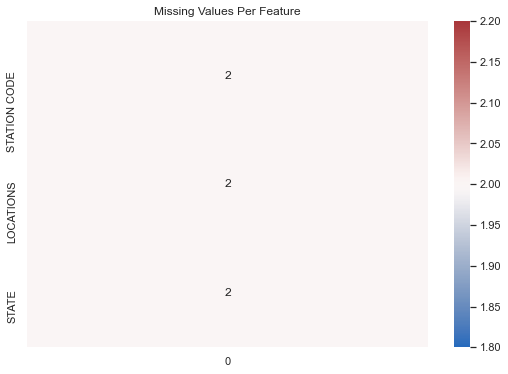

In [202]:
df_res = df_temporaire
plt.title('Missing Values Per Feature')
nans = df_res.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

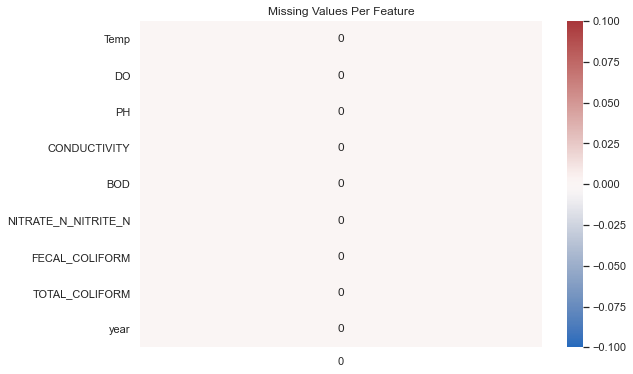

In [203]:
plt.title('Missing Values Per Feature')
nans = df_num.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

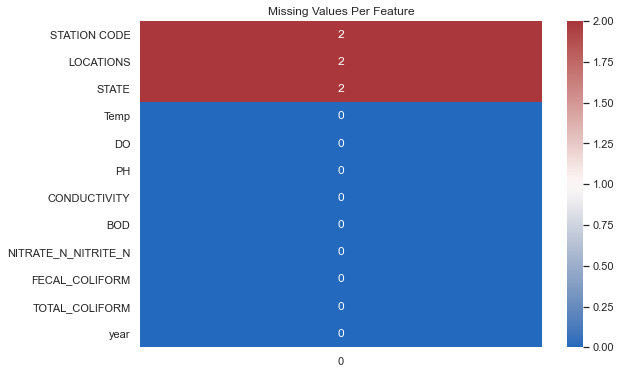

In [204]:
df_final = pd.concat([df_res, df_num], axis=1)
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

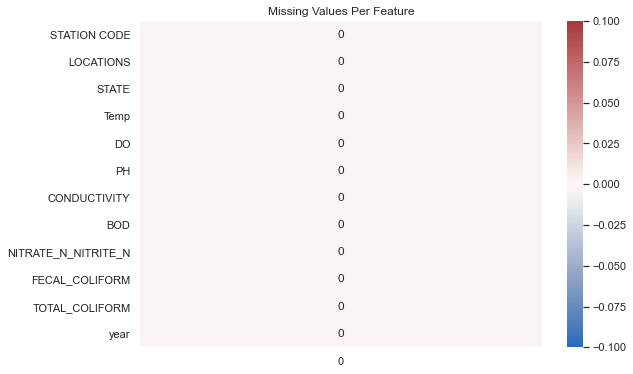

In [205]:
# Ce sont les exemples qui ne contiennent aucun attribut
# Les attributs remplis sont la médiane des colonnes correspondantes
# Il est donc préférable de les supprimer
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

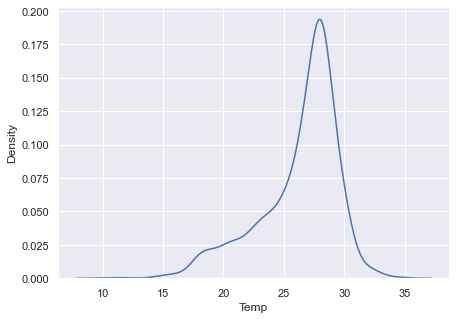

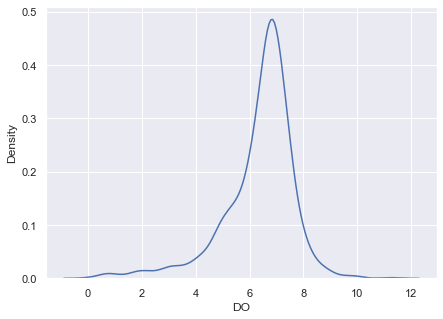

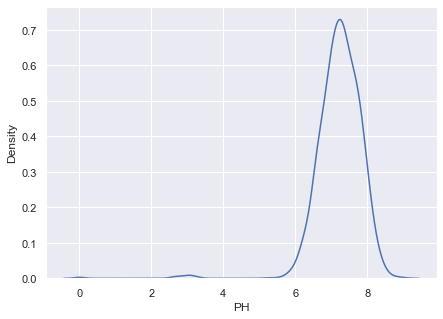

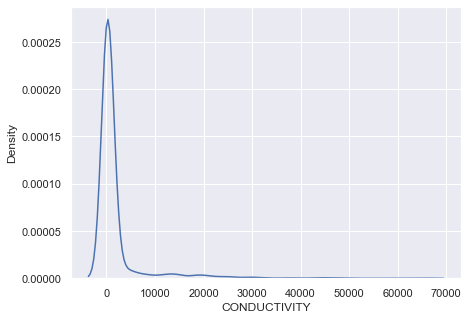

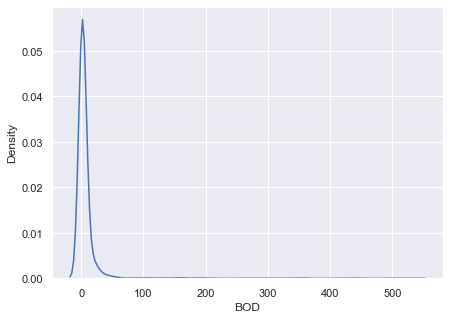

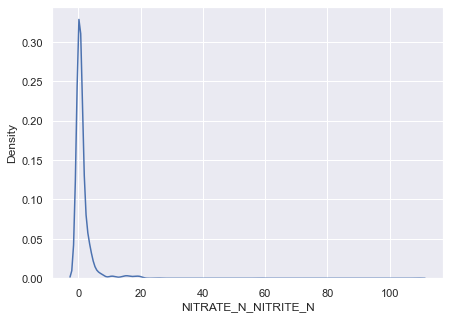

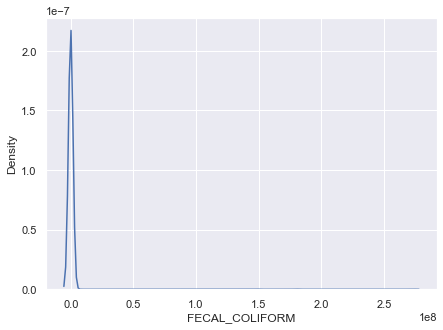

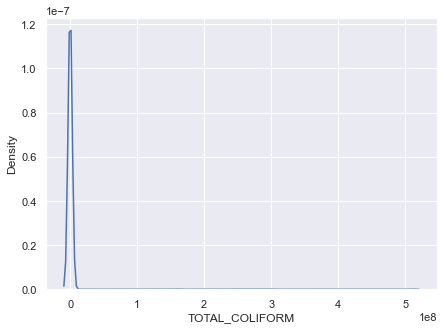

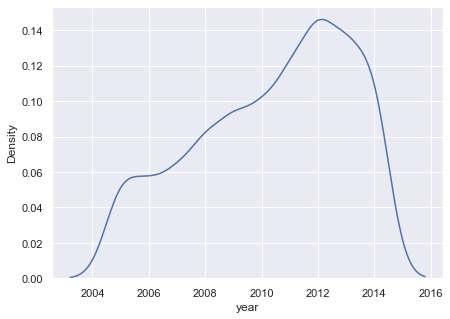

In [206]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [207]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_final.iloc[indices_arr, :]


Number of outliers using Z-Score method:  125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.10,4.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.10,4.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [208]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1786, 12)

C:\Users\amine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BOD', ylabel='Density'>

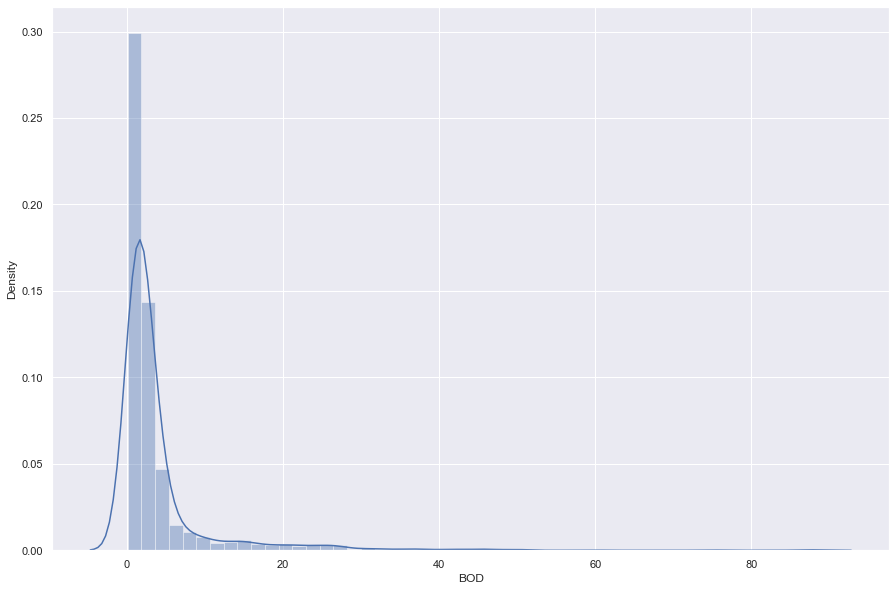

In [209]:
sns.set(rc={'figure.figsize':(15,10)})
fig, (ax1)=plt.subplots(1,1)
sns.distplot(df_final['BOD'], ax=ax1)

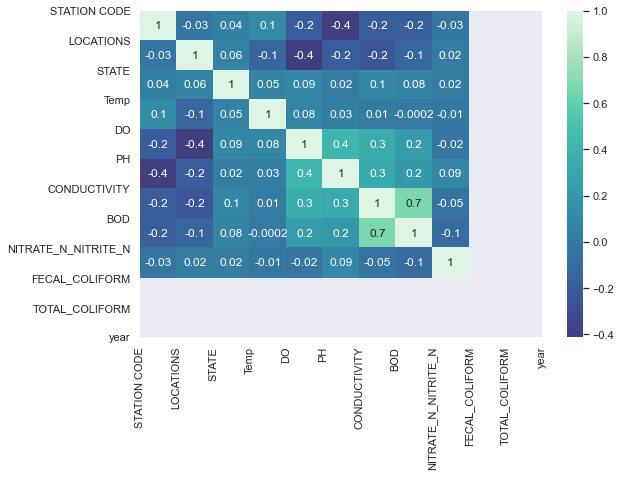

In [210]:
sns.set(rc={'figure.figsize':(9,6)})
hmap = sns.heatmap(df_final.corr(),center=0,annot=True, fmt='.1g', cmap="mako")
plt.xticks(range(len(df_final.columns)),df_final.columns)
plt.yticks(range(len(df_final.columns)),df_final.columns)
plt.show()

mean by state

In [274]:
df=pd.read_csv("Data/water_dataX.csv")
gdf = gpd.read_file('Data/india-states/Igismap/Indian_States.shp')
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes
df = df.iloc[0:1901, :]

In [275]:
#convertir le types des donneés d'un certains variables en float
df['Temp']=pd.to_numeric(df['Temp'], errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'], errors='coerce')
df['PH']=pd.to_numeric(df['PH'], errors='coerce')
df['CONDUCTIVITY (�mhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (�mhos/cm)'], errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'], errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'], errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

In [276]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'D.O. (mg/l)': 'DO'})
df = df.rename(columns={'CONDUCTIVITY (�mhos/cm)': 'CONDUCTIVITY'})
df = df.rename(columns={'B.O.D. (mg/l)': 'BOD'})
df = df.rename(columns={'NITRATENAN N+ NITRITENANN (mg/l)': 'NITRATE_N_NITRITE_N'})
df = df.rename(columns={'FECAL COLIFORM (MPN/100ml)': 'FECAL_COLIFORM'})
df = df.rename(columns={'TOTAL COLIFORM (MPN/100ml)Mean': 'TOTAL_COLIFORM'})
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014


In [277]:
df.shape

(1901, 12)

In [278]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

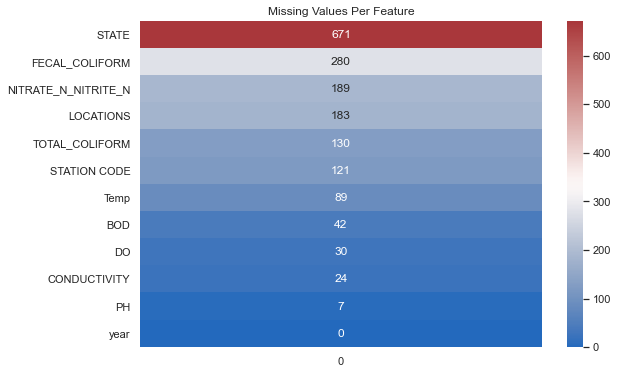

In [279]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [280]:
# Filling Categorical missing values
df_temp = df.select_dtypes(include="object")
df_temp.isnull().sum()

STATION CODE    121
LOCATIONS       183
STATE           671
dtype: int64

In [281]:
# ici on peut remplir ces valeurs par observer les autres attributs
# Exemple - 
pd.set_option('mode.chained_assignment', None)
df_temporaire = df_temp.copy()

df_temporaire[df_temporaire["STATION CODE"] == "1330"]
# Station Code qui a la valeur 1330 du Location - TAMBIRAPARANI qui appartient à STATE - TAMIL NADU
#je peux remplacer les occuerences du valeur NAN dans la case STATE par TAMILNADU
df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"] = df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [282]:
# Les valeurs NULL dans l’attribut LOCATION sont dans l’attribut STATE (ex - au-dessus du dataframe)
# Ainsi, je remplirai les valeurs NULL dans l’attribut LOCATION avec la valeur STATE correspondante
# Et la valeur d’état sera remplacée par la fonction "fill_state" définie en dessous de cette cellule

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [283]:
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [284]:
# je peux remplir les valeurs NULL du code de la station avec la valeur LOCATION correspondante (ex - au-dessus de la base de données)
#je vais faire la valeur LOCATION correspondante avec une autre valeur LOCATION identique et insérera la valeur du code station

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_temporaire)
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [285]:
# Remplissage de toutes les valeurs NAN d’état qui ont une valeur de code de station correspondante
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [286]:
df_temporaire.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [287]:
df_temporaire[df_temporaire["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [288]:
# Le premier emplacement KABBANI AT MUTHANKARA est dans l’ÉTAT Kerela
df_temporaire["STATE"][1106] = "KERALA"
df_temporaire["STATE"][1107] = "KERALA"
df_temporaire["STATE"][1650] = "CHANDIGARH"
df_temporaire["STATE"][1651] = "CHANDIGARH"
df_temporaire["STATE"][1652] = "CHANDIGARH"
df_temporaire["STATE"][1770] = "CHANDIGARH"
df_temporaire["STATE"][1771] = "CHANDIGARH"
df_temporaire["STATE"][1772] = "CHANDIGARH"
df_temporaire["STATE"][1784] = "DAMAN & DIU"
df_temporaire["STATE"][1785] = "DAMAN & DIU"
df_temporaire["STATION CODE"][1784] = "0000" 
df_temporaire["STATION CODE"][1785] = "0000"

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

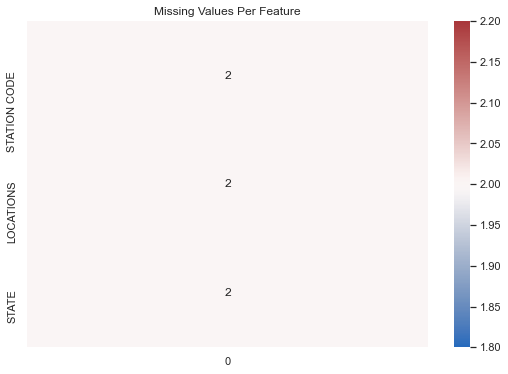

In [289]:
df_res = df_temporaire
plt.title('Missing Values Per Feature')
nans = df_res.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [290]:
df_num = df.select_dtypes(exclude="object")# Selectioner les donneés numériques
df_num_col = df_num.columns 

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

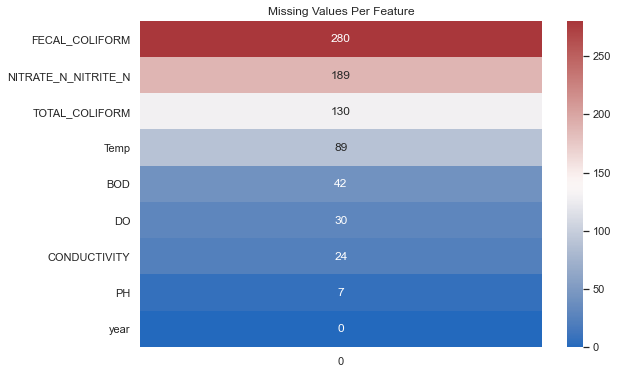

In [291]:
plt.title('Missing Values Per Feature')
nans = df_num.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

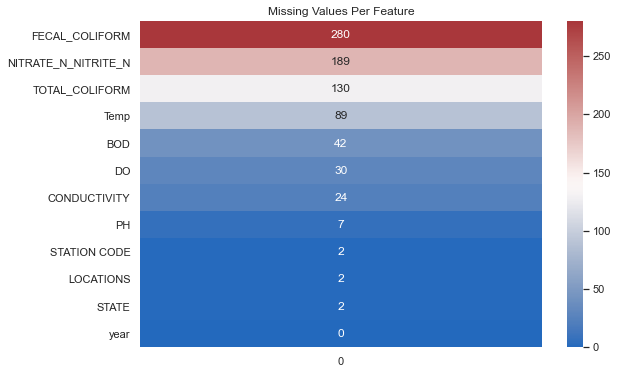

In [292]:
df_final = pd.concat([df_res, df_num], axis=1)
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

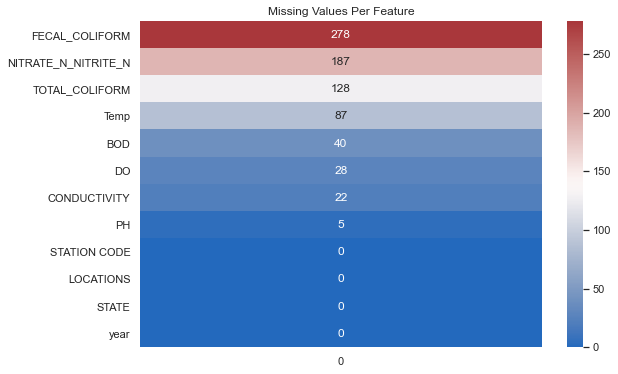

In [293]:
# Ce sont les exemples qui ne contiennent aucun attribut
# Les attributs remplis sont la médiane des colonnes correspondantes
# Il est donc préférable de les supprimer
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [294]:
B=set()
for i in df_final['STATE']:
    B.add(i)
print(B)

{'ORISSA', 'PONDICHERRY', 'TRIPURA', 'KARNATAKA', 'TAMIL NADU', 'MIZORAM', 'PUNJAB', 'HIMACHAL PRADESH', 'ODISHA', 'ANDHRA PRADESH', 'RAJASTHAN', 'HARYANA', 'MEGHALAYA', 'MADHYA PRADESH', 'CHANDIGARH', 'KERALA', 'tripura', 'TAMILNADU', 'GOA', 'DAMAN, DIU, DADRA NAGAR HAVELI', 'MANIPUR', 'GUJARAT', 'MAHARASHTRA', 'DAMAN & DIU'}


In [295]:
# remplacer les valeurs manquantes de chaque colonne par la moyenne de cette colonne pour toutes les lignes qui ont le même état
df_clean = df_final.fillna(df_final.groupby('STATE').transform('mean'))

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

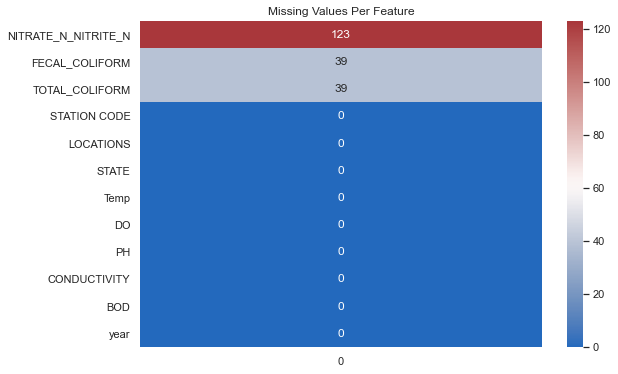

In [296]:
plt.title('Missing Values Per Feature')
nans = df_clean.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [297]:
df_clean.shape

(1899, 12)

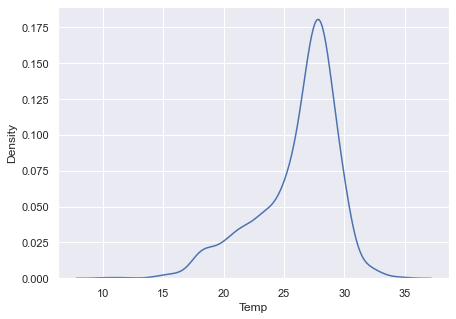

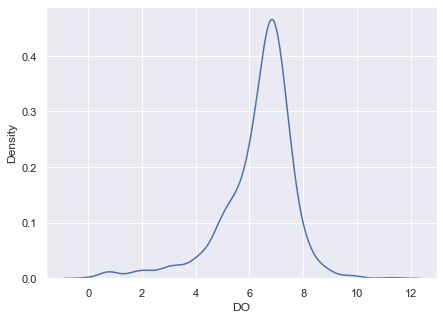

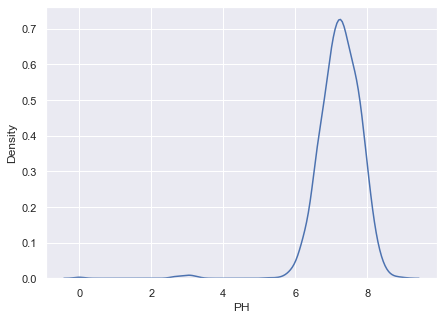

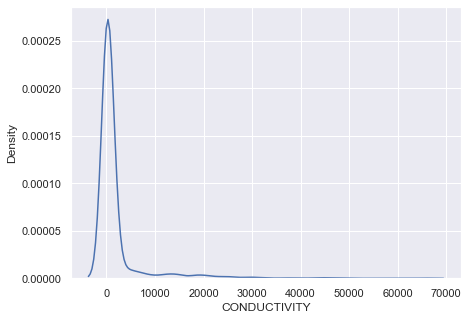

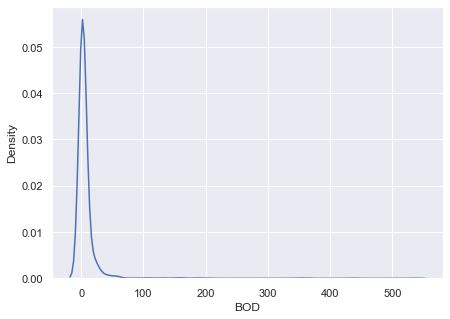

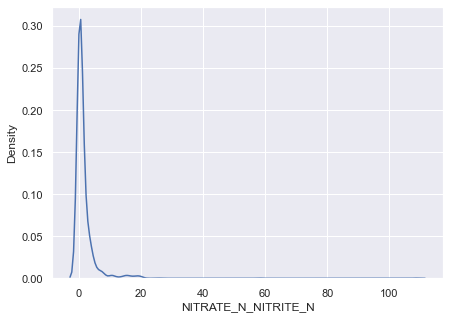

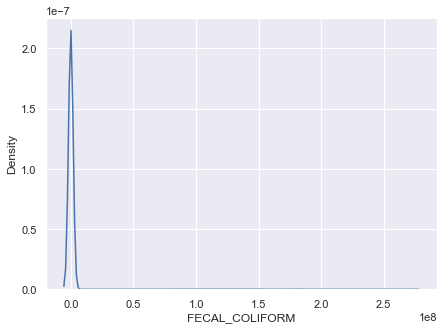

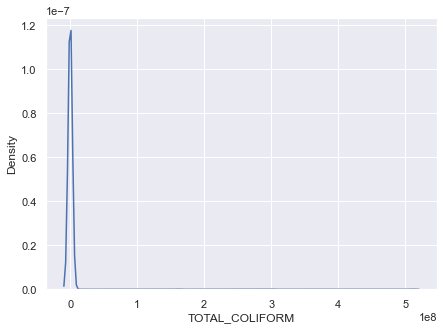

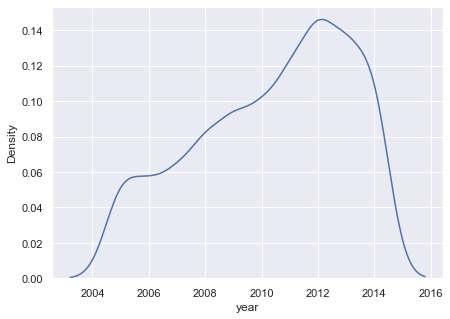

In [298]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_clean.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [299]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_clean.iloc[indices_arr, :]

Number of outliers using Z-Score method:  79


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.00000,8.2,7.60,112.0,2.100,NaN,100.0,31.0,2012
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.00000,9.3,7.60,193.0,2.300,NaN,100.0,41.0,2012
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.30000,5.3,7.70,24062.0,9.900,1.200,156.0,304.0,2014
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.30000,3.7,7.70,32005.0,1.200,0.900,40000.0,60392.0,2014
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.00000,5.6,7.20,24360.0,2.100,0.300,92.0,447.0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
1773,1427,"UMTREW AT BYRNIHAT EAST, MEGHALAYA",MEGHALAYA,16.00000,7.2,7.00,183.0,5.200,2.600,140.0,180.0,2006
1774,1428,"KHARKHLA NEAR SUTNGA KHLIERIAT,JAINTIA HILLS D...",MEGHALAYA,15.00000,4.6,3.00,350.0,6.200,2.200,33.0,49.0,2006
1787,1246,"DAMANGANGA AT KACHIGAON D\S (DAMAN),GUJARAT",GUJARAT,27.00000,5.0,7.22,18370.3,19.663,0.452,9625.0,13525.0,2005
1807,1438,"MINDHOLA AT STATE HIGHWAY BRIDGE SACHIN, GUJARAT",GUJARAT,27.67791,6.1,8.00,602.5,5.640,1.035,38143.0,38428.0,2005


In [300]:
df_clean.drop(indices_arr, axis=0, inplace=True)
df_clean.shape

(1823, 12)

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

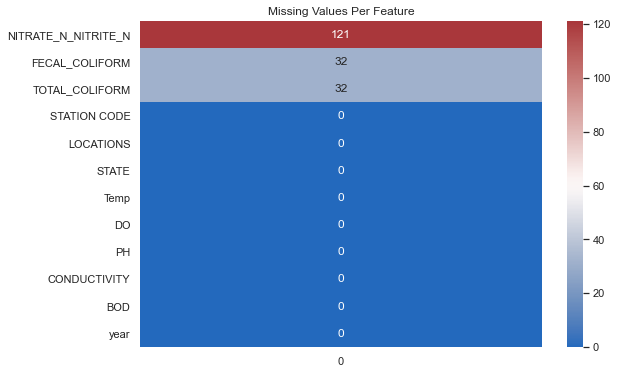

In [301]:
plt.title('Missing Values Per Feature')
nans = df_clean.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [302]:
df_clean=df_clean.dropna()

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

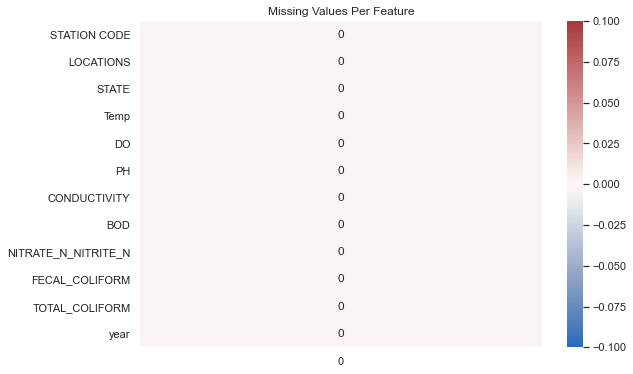

In [303]:
plt.title('Missing Values Per Feature')
nans = df_clean.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

C:\Users\amine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BOD', ylabel='Density'>

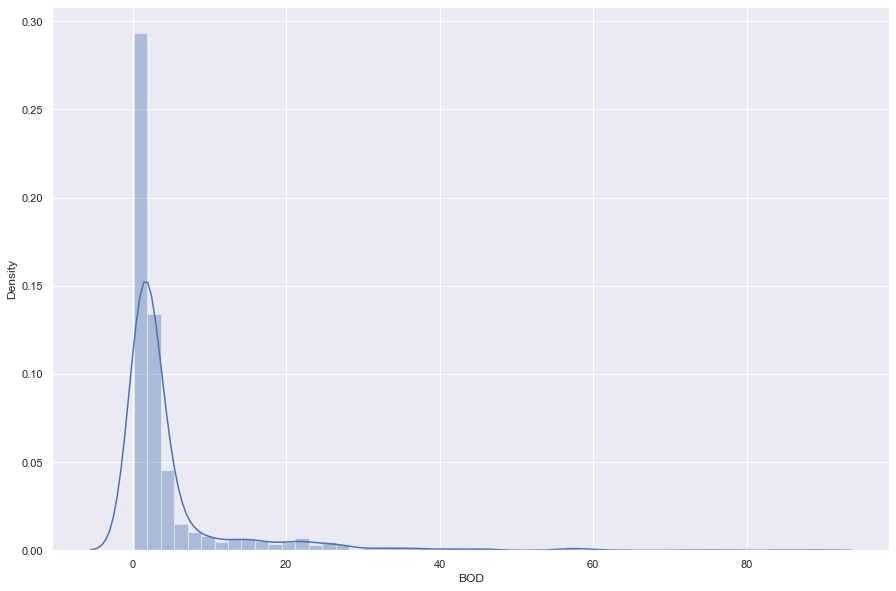

In [304]:
sns.set(rc={'figure.figsize':(15,10)})
fig, (ax1)=plt.subplots(1,1)
sns.distplot(df_clean['BOD'], ax=ax1)

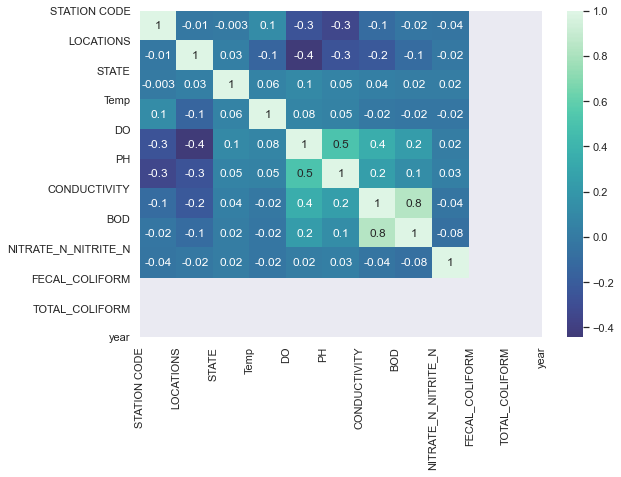

In [305]:
sns.set(rc={'figure.figsize':(9,6)})
hmap = sns.heatmap(df_clean.corr(),center=0,annot=True, fmt='.1g', cmap="mako")
plt.xticks(range(len(df_clean.columns)),df_clean.columns)
plt.yticks(range(len(df_clean.columns)),df_clean.columns)
plt.show()

In [306]:
df_clean.shape

(1670, 12)